In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats,integrate
import pandas as pd
import seaborn as sns

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


The integral of the original histogram --> 106.61961415810244
The integral of the normalized of sumation of all G-F --> 106.83328071493675


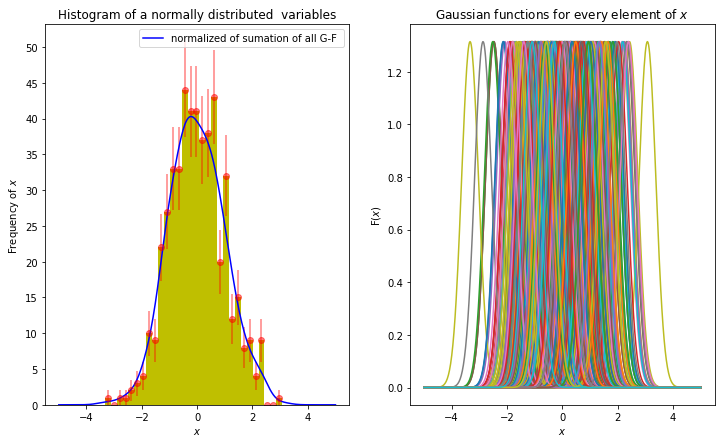

In [128]:
# numpy array with normally distributed....
mu, sigma, n = 0, 1, 500 
x = np.random.normal(mu, sigma, n)

# histogram in pyplot.... 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
a = ax1.hist(x, bins=30,color="y", alpha=1)# a[0] is our bins and a[1] is our range
ax1.set_title('Histogram of a normally distributed  variables')
ax1.set_xlabel('$x$')
ax1.set_ylabel('Frequency of $x$')

# data points with errors.... 
b = []
for i in range(len(a[1])-1):#finding the bin centers for the error bar
    b.append((a[1][i]+a[1][i+1])/2)
    
ax1.errorbar(b,a[0],a[0]**(0.5),fmt = "o",color = "r",alpha = 0.5)

#proper value of y axis 
m=int(max(a[0]))+int(max(a[0]**(0.5)))+5
ax1.set_yticks(range(0,m,5))

# create a gaussian for every element of x and plot all the gaussian functions....
x_min = int(a[1][0])-2*(sigma) # -2*(sigma)  and +2*(sigma) is for we create gaussian for a[1][0] and a[1][int(len(a[1]))-1] 
x_max = int(a[1][int(len(a[1]))-1])+2*(sigma)
x_lin = np.linspace(x_min, x_max, 500)
G = []
for i in range(len(x)):
    g = stats.norm(loc = x[i], scale = 1.06*(x.std()*(x.size**(-1/5)))).pdf(x_lin)
    G.append(g)
    ax2.plot(x_lin, g)
ax2.set_title('Gaussian functions for every element of $x$')
ax2.set_xlabel('$x$')
ax2.set_ylabel('F($x$)') 

#normalized of sumation of all gaussian functions .... 
s_G = np.sum(np.array(G),axis = 0)
int_n_s_G = integrate.trapz(s_G*(b[1]-b[0]),x_lin) #normalized 
int_x = integrate.trapz(a[0],b)

print("The integral of the original histogram -->",int_x)
print("The integral of the normalized of sumation of all G-F -->",int_n_s_G)

ax1.plot(x_lin, s_G*(b[1]-b[0]),color="b", alpha=1, label="normalized of sumation of all G-F ")
ax1.legend()
plt.show()


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2021-12-08 21:58:37--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [following]
--2021-12-08 21:58:38--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc319031aeaabed61fc9c1efe5d6.dl.dropboxusercontent.com/cd/0/inline/Bbc5pNBADhtFkQoAOt6RfK_RUyVh25X7ZnxRZxBODNRzOFNgo9PovDjYwLvg1CpmLPspQ3iblxzsyqAh036FSt-DOo_Q_twak3jZg3xuTH6R52kvEA0ZhS9VyTEYSmBm9v440rzTDUFNAjbBbpb6hCCG/file# [following]
--2021-12-08 21:58:38--  https://uc319031aeaabed61fc9c1efe5d6.dl.dropboxusercontent.com/cd/0/inline/Bbc5pNBADhtFkQoAOt6RfK_RUyVh25

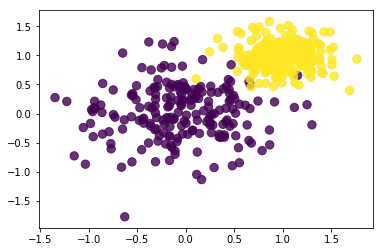

In [129]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

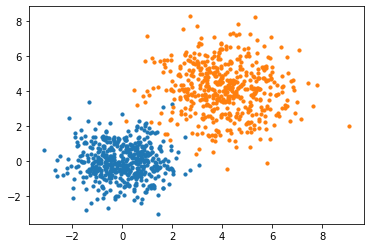

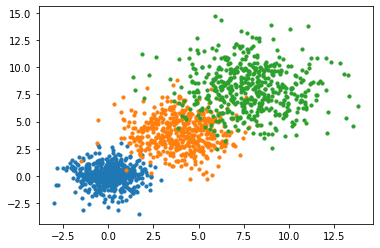

In [162]:
def D2_gaussian (n,mean, cov, size):
    x_t = []
    y_t = []
    for i in range(n):
        x, y =np.random.multivariate_normal(mean[i], cov[i], size[i]).T
        x_t.append(x)
        y_t.append(y)
    return x_t,y_t 

x_t, y_t = D2_gaussian (2,[[0,0],[4,4]], [[[1,0],[0,1]],[[2,0],[0,2]]],[500,500])
for i in range(2):
    plt.scatter(x_t[i], y_t[i],s=10)    
plt.show()

x_t, y_t = D2_gaussian (3,[[0,0],[4,4],[8,8]], [[[1,0],[0,1]],[[2,0],[0,2]],[[4,0],[0,4]]],[500,500,500])
for i in range(3):
    plt.scatter(x_t[i], y_t[i],s=10)

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [2]:
#Download .....

!wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy

--2021-12-09 23:06:26--  https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.69.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.69.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hgnvyj9abatk8g6/residuals_261.npy [following]
--2021-12-09 23:06:27--  https://www.dropbox.com/s/raw/hgnvyj9abatk8g6/residuals_261.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2be7b5fa7312e4822a806386cb.dl.dropboxusercontent.com/cd/0/inline/BbjU1L30ENlLPdu4LFHIixb8shimbiVXI1gMDwRwNoM67UTZ84w-mQ51zMUbhEpkYrk_HIyRQPxwyUQjY03XeMrzykTvpSSTDcWM-8At1reEgPBjZInU4TkupQfWaGZC5q7mxpGsQNeTJKTesVQ8x8YX/file# [following]
--2021-12-09 23:06:27--  https://uc2be7b5fa7312e4822a806386cb.dl.dropboxusercontent.com/cd/0/inline/BbjU1L30ENlLPdu4LFHIixb8shimbiVXI1gMDwRwNoM67UTZ84w-mQ51zMUbhEpkYrk_HIyR

In [2]:
#use the np.load() function and the .item() method ...

l_f = pd.DataFrame(np.load('residuals_261.npy',allow_pickle = True).item())
l_f.head()

,residuals,distances
0,1.10,16.0
1,-1.95,6.3
2,-7.20,3.4
3,-4.15,8.4
4,-6.59,1.7


In [3]:
#Clean the sample with the variable "residual" in absolute value smaller than 2

f_r_2 = l_f[abs(l_f["residuals"])<2]
f_r_2.head()

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0


In [4]:
#perform a linear regression 

result = stats.linregress(f_r_2["distances"],f_r_2["residuals"])

/home/reza/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


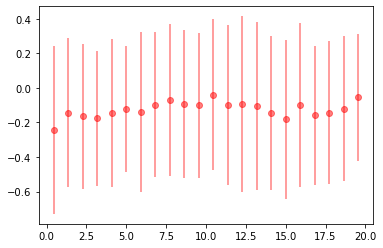

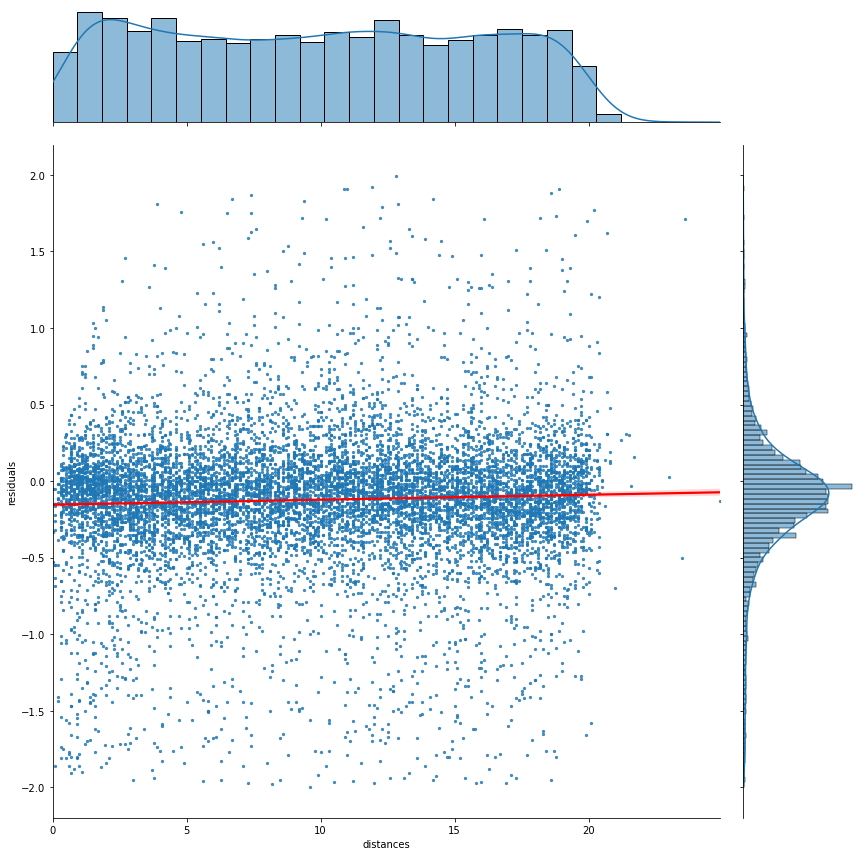

In [7]:

#Plot the profile plot 

x_l = np.linspace(0, 20, 23) 
x = []
for i in range(22):
    x.append((x_l[i]+x_l[i+1])/2)
y = []
error = []
for i in range(len(x_l)-1):
    f_i = f_r_2[(f_r_2["distances"] >= x_l[i]) & (f_r_2["distances"] < x_l[i+1])]
    y.append(f_i["residuals"].mean()) 
    error.append(f_i["residuals"].std())
    
x = np.array(x)
y = np.array(y)
error = np.array(error)

plt.errorbar(x, y, error,fmt = "o",color = "r",alpha = 0.5)

#plot a seaborn jointplot 

sns.jointplot("distances", "residuals", data = f_r_2, kind = "reg",height = 12,
                  scatter_kws = {"s":5}, line_kws = {"color":"r"})


plt.show()